# Project - Housing Prices in San Francisco
# Linear Regression


In this project, I am developing a linear regression model to predict the `price` of San Francisco apartment rentals. I am following a structured workflow to ensure thorough and accurate results.

1. The dataset has already undergone data cleaning.
2. I will begin by exploring the data, focusing on identifying valuable features and spotting potential patterns.
3. I will then select an appropriate model validation approach, considering both simple validation and cross-validation techniques.
4. After that, I will fit the Linear Regression model to the data.
5. I will carefully evaluate the model, checking assumptions, metrics, and examining the coefficient estimates.
6. If necessary, I will engineer new features to improve the model's performance.
7. I will iterate through steps 2, 4, 5, and 6 as needed, refining the model continuously.
8. Once the model is finalized, I will assess its performance on the test data, reporting the final R-squared and MAE to gauge the model's effectiveness.

A reasonable goal is to get a validation MAE of <.
 500 dollars.

- data is taken from Kaggle Data Sets: https://www.kaggle.com/datasets/thedevastator/scraping-apartments-off-of-craigslist-in-san-fra

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
    
import scipy.stats as stats

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Suppress specific warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


In [180]:
rentals_df = pd.read_csv("sf_clean.csv")

rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [181]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA

1. Given the range of prices in the dataset, it might be necessary to filter the data to focus on predicting prices for more "realistic" apartments. A potential approach could be to subset the data based on square footage.

2. The 'hood_district' feature, which was read as an integer, is actually a categorical variable. I'll need to correct this by converting it to the appropriate categorical format.


In [182]:
rentals_df["hood_district"] = rentals_df["hood_district"].astype("object") 

In [183]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


There are some very rare, expensive apartments that cost over 10K$.

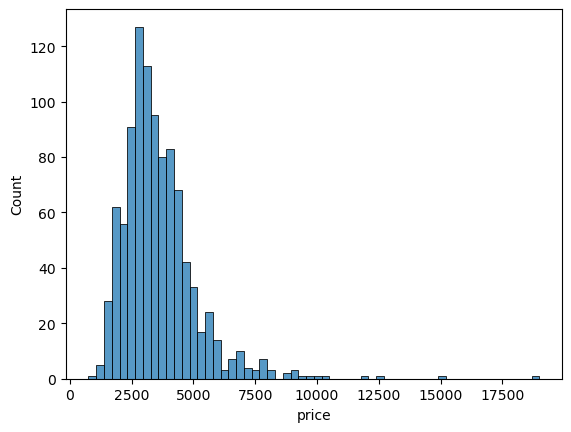

In [184]:
sns.histplot(rentals_df, x="price");

Most of the numeric features in our dataset show positive correlations with each other, which could potentially lead to issues. However, it's encouraging to see that some of these features also have strong correlations with our target variable.

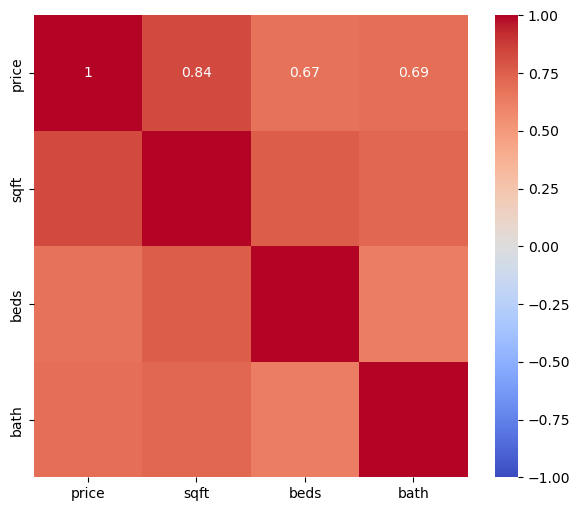

In [209]:
plt.figure(figsize=(7, 6))
sns.heatmap(
    rentals_df.corr(numeric_only=True), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=True
);

Based on the pairplot below, it seems we could refine our analysis by focusing on apartments that are less than 2,500 square feet, which would allow us to exclude the most expensive units from our dataset.

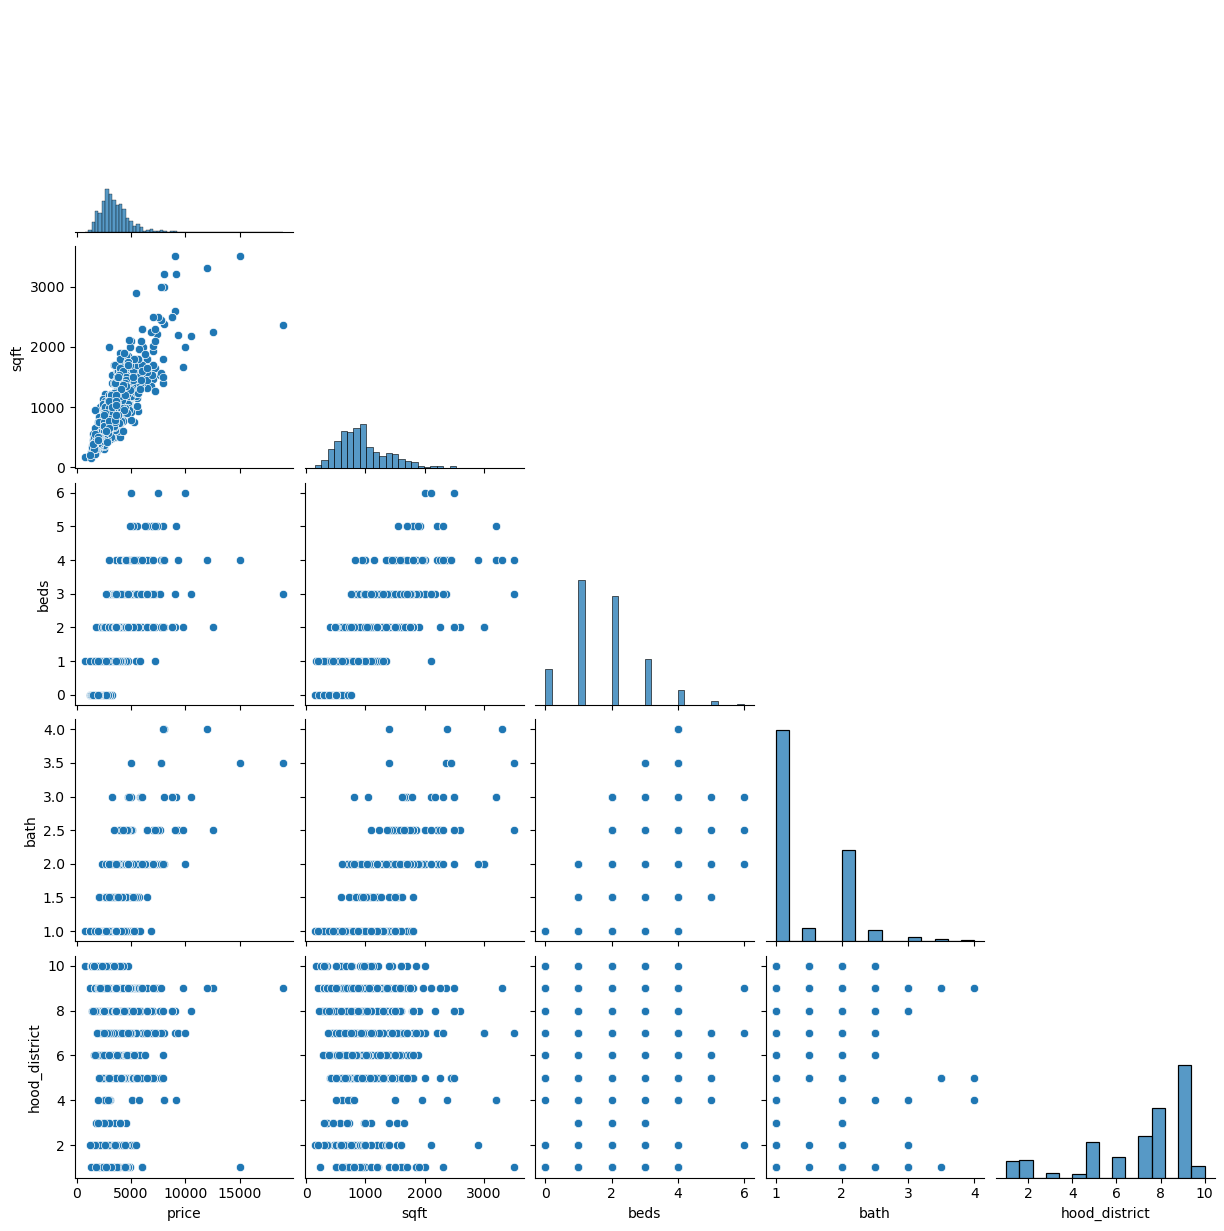

In [186]:
sns.pairplot(rentals_df, corner=True)

When analyzing our categorical features, we identified some rare categories that might need to be combined for more effective modeling.

We should consider the following adjustments:

1. Pets: Combine the 'dogs' and 'both' categories into a single 'allows_dogs' category.
2. Housing Type: Group the 'multi' and 'double' categories together.
3. Parking: Merge 'protected', 'off-street', and 'valet' into one category.
4. Neighborhoods: Some of the neighborhoods with lower counts could be binned with adjacent ones. We should examine the average pricing for each neighborhood to determine which ones are similar in terms of price and can be grouped together.

In [187]:
# Let's check the frequency of our categorical features

def value_counter(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
        
        
value_counter(rentals_df)

laundry
(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64
pets
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64
housing_type
(c) multi     937
(a) single     40
(b) double     12
Name: count, dtype: int64
parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: count, dtype: int64
hood_district
9.0     332
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: count, dtype: int64


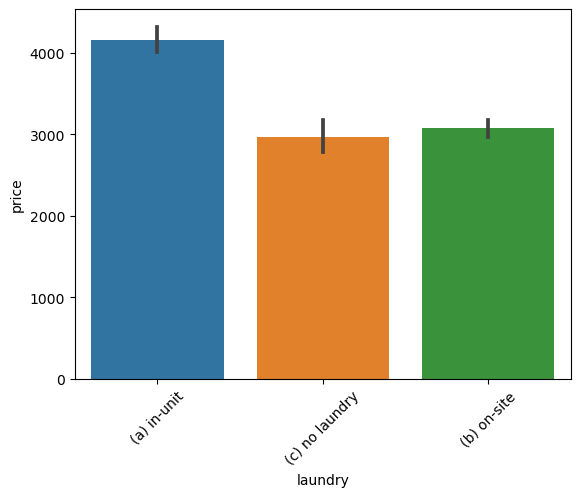

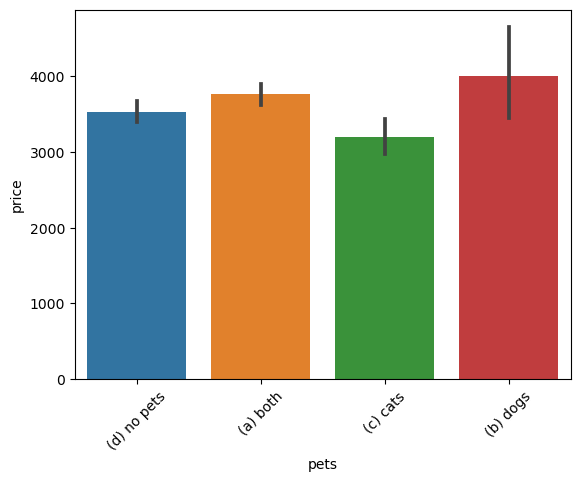

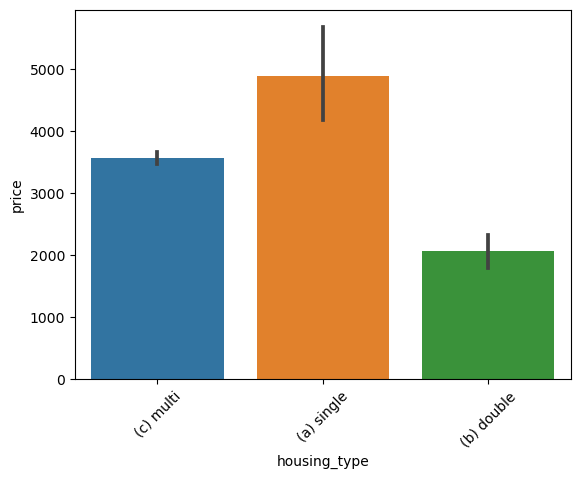

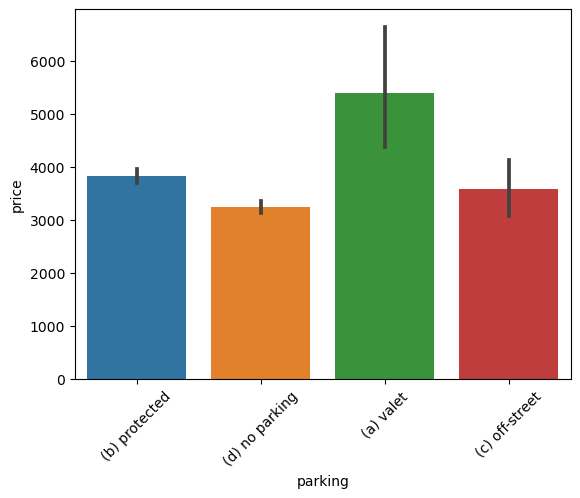

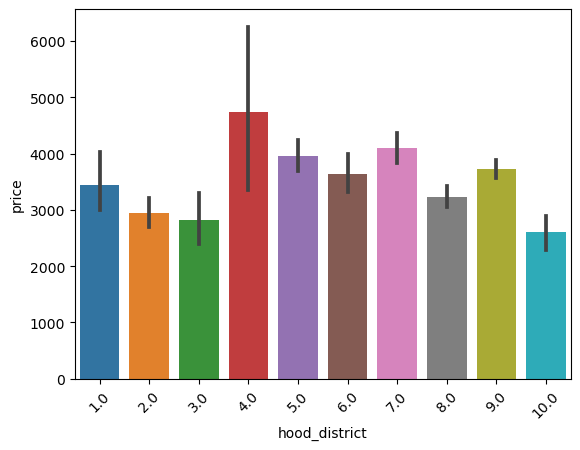

In [188]:
def cat_plotter(data, target):
    for col in data.select_dtypes(["object"]).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()
        
cat_plotter(rentals_df, "price")

# Feature Engineering

1. Group Categories Together: Combine certain categories to simplify and enhance the analysis.
2. Introduce Squared Terms: Experiment with adding squared terms for the bedrooms, square footage, and bathrooms variables to capture potential non-linear relationships.

In [189]:
laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}
pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}
housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}
district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "north",
    8.0: "northeast",
    9.0: "centraleast",
    10.0: "southwest"   
}

In [190]:
df_eng = rentals_df.assign(
    hood_district = rentals_df["hood_district"].map(district_map),
    housing_type = rentals_df["housing_type"].map(housing_type_map),
    pets = rentals_df["pets"].map(pet_map),
    laundry = rentals_df["laundry"].map(laundry_map),
    sqft2 = rentals_df["sqft"] ** 2,
#     sqft3 = rentals_df["sqft"] ** 3,
#     beds2 = rentals_df["beds"] ** 2,
#     beds3 = rentals_df["beds"] ** 3,
#     bath2 = rentals_df["bath"] ** 2,
#     bath3 = rentals_df["bath"] ** 3,
    beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"]
)

df_eng = pd.get_dummies(df_eng, drop_first=True, dtype=int)

In [191]:
df_eng.head()

,price,sqft,beds,bath,sqft2,beds_bath_ratio,laundry_not_in_unit,pets_no_dogs,housing_type_single,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_centraleast,hood_district_north,hood_district_northeast,hood_district_southwest,hood_district_west
0,6800,1600.0,2.0,2.0,2560000.0,1.0,0,1,0,1,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,302500.0,1.0,0,0,0,1,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,1690000.0,2.0,0,0,0,0,0,1,0,1,0,0,0
3,9000,3500.0,3.0,2.5,12250000.0,1.2,0,1,0,1,0,0,0,1,0,0,0
4,3100,561.0,1.0,1.0,314721.0,1.0,1,0,0,0,0,1,0,1,0,0,0


In [192]:
target = "price"
drop_cols = ["pets_no_dogs",
             "housing_type_single", 
             "beds_bath_ratio"
             ]

X = sm.add_constant(df_eng.drop([target] + drop_cols, axis=1))

# Log transform slightly improves normality
y = np.log(df_eng[target])
# y = df_eng[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=347)

In [193]:
def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=347)
    # Create a list to store validation scores for each split

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.821, 0.806, 0.816, 0.805, 0.817]
Training R2s: 0.813 +- 0.006
Training MAEs: [0.123, 0.127, 0.125, 0.125, 0.124]
Training MAEs: 0.125 +- 0.001
All Validation R2s: [0.778, 0.837, 0.791, 0.834, 0.79]
Cross Val R2s: 0.806 +- 0.025
All Validation MAEs: [0.132, 0.118, 0.124, 0.125, 0.133]
Cross Val MAEs: 0.127 +- 0.005


In [194]:
# Model p-values: a few features have > .05
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     212.0
Date:                Tue, 03 Sep 2024   Prob (F-statistic):          6.45e-218
Time:                        20:35:32   Log-Likelihood:                 253.16
No. Observations:                 633   AIC:                            -478.3
Df Residuals:                     619   BIC:                            -416.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.5560      0.054    140.313      0.000       7.450       7.662
sqft                          0.0007   5.73e-05     12.742      0.000       0.001       0.001
beds                          0.0718      0.011      6.377      0.000       0.050       0.094
bath                          0.0463      0.018      2.567      0.010       0.011       0.082
sqft2                     -9.945e-08   1.58e-08     -6.300      0.000    -1.3e-07   -6.84e-08
laundry_not_in_unit          -0.0774      0.016     -4.910      0.000      -0.108      -0.046
parking_(b) protected        -0.1284      0.036     -3.589      0.000      -0.199      -0.058
parking_(c) off-street       -0.1365      0.048     -2.826      0.005      -0.231      -0.042
parking_(d) no parking       -0.1984      0.037     -5.317      0.000      -0.272      -0.125
hood_district_centraleast    -0.0123      0.020     -0.602      0.547      -0.052       0.028
hood_district_north           0.0561      0.024      2.297      0.022       0.008       0.104
hood_district_northeast      -0.0160      0.021     -0.760      0.447      -0.057       0.025
hood_district_southwest      -0.2076      0.026     -7.895      0.000      -0.259      -0.156
hood_district_west           -0.0642      0.032     -2.010      0.045      -0.127      -0.001
==============================================================================
Omnibus:                       25.713   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.347
Skew:                           0.185   Prob(JB):                     3.53e-13
Kurtosis:                       4.427   Cond. No.                     2.17e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I've reviewed the linearity assumptions:

1. Linearity: There’s no apparent curvature in the data.
2. Independence: The Durbin-Watson test statistic looks good, indicating no issues with independence.
3. Normality: There was a slight deviation from normality before applying the log transform, but it improved significantly afterward. However, using the log transform might impact interpretability.
4. No Perfect Multicollinearity: The Variance Inflation Factors (VIFs) are within acceptable ranges.
5. Equal Variance: There was slight heteroskedasticity before the log transform.

In [195]:
def residual_analysis_plots(model):
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   

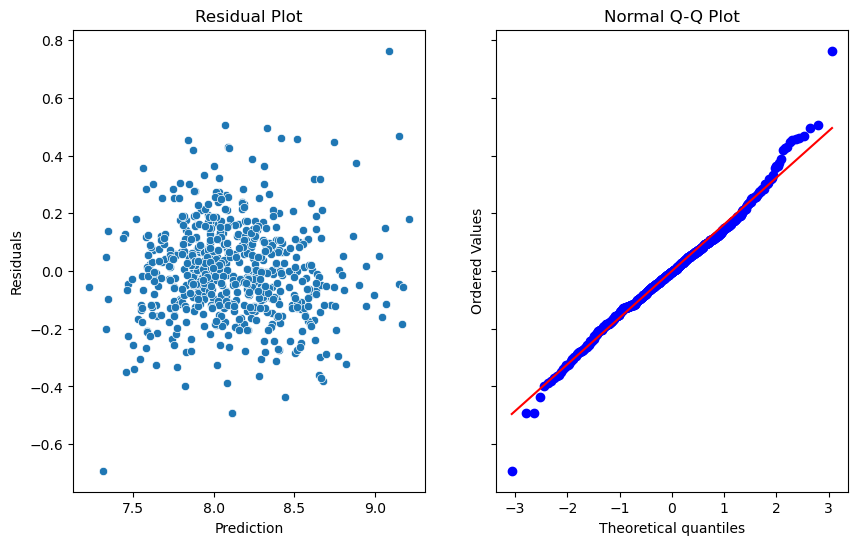

In [196]:
residual_analysis_plots(model)

In [197]:
# The VIF values look acceptable overall—though our parking dummy variables are slightly high, it's not a major concern.

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                        69.922385
sqft                         17.564636
beds                          3.204561
bath                          2.276195
sqft2                        11.426680
laundry_not_in_unit           1.391649
parking_(b) protected         7.943120
parking_(c) off-street        2.260252
parking_(d) no parking        8.646868
hood_district_centraleast     2.074237
hood_district_north           1.481877
hood_district_northeast       1.751145
hood_district_southwest       1.409719
hood_district_west            1.240309
dtype: float64

In [198]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

11     0.187022
253    0.116686
56     0.046699
863    0.027973
585    0.022759
Name: cooks_d, dtype: float64

## Linear Regression - Final Model Fit

In [199]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     259.0
Date:                Tue, 03 Sep 2024   Prob (F-statistic):          7.83e-272
Time:                        20:35:33   Log-Likelihood:                 316.28
No. Observations:                 791   AIC:                            -604.6
Df Residuals:                     777   BIC:                            -539.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.5890      0.049    155.947      0.000       7.493       7.685
sqft                          0.0007   5.17e-05     13.864      0.000       0.001       0.001
beds                          0.0751      0.010      7.665      0.000       0.056       0.094
bath                          0.0437      0.016      2.749      0.006       0.013       0.075
sqft2                      -1.01e-07   1.46e-08     -6.929      0.000    -1.3e-07   -7.24e-08
laundry_not_in_unit          -0.0689      0.014     -5.020      0.000      -0.096      -0.042
parking_(b) protected        -0.1503      0.033     -4.550      0.000      -0.215      -0.085
parking_(c) off-street       -0.1531      0.044     -3.447      0.001      -0.240      -0.066
parking_(d) no parking       -0.2207      0.034     -6.443      0.000      -0.288      -0.153
hood_district_centraleast    -0.0177      0.018     -0.994      0.321      -0.053       0.017
hood_district_north           0.0591      0.022      2.726      0.007       0.017       0.102
hood_district_northeast      -0.0258      0.019     -1.367      0.172      -0.063       0.011
hood_district_southwest      -0.2067      0.023     -8.967      0.000      -0.252      -0.161
hood_district_west           -0.0732      0.029     -2.531      0.012      -0.130      -0.016
==============================================================================
Omnibus:                       27.315   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.471
Skew:                           0.180   Prob(JB):                     5.46e-13
Kurtosis:                       4.258   Cond. No.                     2.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [200]:
print(mae(np.exp(y_test), np.exp(final_model.predict(X_test)))) 
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}") #468.13 if not transformed
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

488.1291748947526
Test R2: 0.816078501218938


# Regularized Regression

Now, I'll apply regularization techniques, including Lasso, Ridge, and Elastic Net regressions. Afterward, I'll compare their performance to the original regression model.

## Scaling Data

In [201]:
std = StandardScaler()
X_tr = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

### Ridge 

Ridge regression applies an L2 penalty (squared magnitude of coefficients), making it suitable when all predictors contribute to the target variable. 

In [202]:
n_alphas = 100
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_tr, y)
print(f"Cross Val R2: {ridge_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(ridge_model.predict(X_tr)))}")
print(f"Alpha: {ridge_model.alpha_}")

Cross Val R2: 0.8124208226792148
Cross Val MAE: 465.3441240484295
Alpha: 1.232846739442066


In [203]:
list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('sqft', 0.32772481388705),
 ('beds', 0.08205324902671841),
 ('bath', 0.024672126204120463),
 ('sqft2', -0.12806846153240656),
 ('laundry_not_in_unit', -0.03475365414388067),
 ('parking_(b) protected', -0.07269575753341878),
 ('parking_(c) off-street', -0.02943922704440581),
 ('parking_(d) no parking', -0.10873131544394028),
 ('hood_district_centraleast', -0.00794325131825362),
 ('hood_district_north', 0.019595235444851204),
 ('hood_district_northeast', -0.010360499593078913),
 ('hood_district_southwest', -0.061958024138380544),
 ('hood_district_west', -0.01635168087115075)]

## Lasso

Lasso regression uses an L1 penalty, which can shrink coefficients to zero, effectively performing feature selection—useful when you suspect only a few predictors are important. 

In [204]:
n_alphas = 200
alphas = 10 ** np.linspace(-2, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_tr, y)

print(f"Cross Val R2: {lasso_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(lasso_model.predict(X_tr)))}")
print(f"Alpha: {lasso_model.alpha_}")

Cross Val R2: 0.7915933430364682
Cross Val MAE: 490.10021309453793
Alpha: 0.01


In [205]:
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('sqft', 0.19248242211204986),
 ('beds', 0.09674809712903253),
 ('bath', 0.021808924655765182),
 ('sqft2', -0.0),
 ('laundry_not_in_unit', -0.036008879410692),
 ('parking_(b) protected', -0.0),
 ('parking_(c) off-street', -0.0),
 ('parking_(d) no parking', -0.03775111948653123),
 ('hood_district_centraleast', 0.0),
 ('hood_district_north', 0.015476642320532884),
 ('hood_district_northeast', -0.0),
 ('hood_district_southwest', -0.05281044387237145),
 ('hood_district_west', -0.0064229662599705716)]

## ENet

In [206]:
alphas = 10 ** np.linspace(-2, 3, 200)
l1_ratios = np.linspace(.01, 1, 100)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

enet_model.fit(X_tr, y)

print(f"Cross Val R2: {enet_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(enet_model.predict(X_tr)))}")
print(f"Alpha: {enet_model.alpha_}")
print(f"L1_Ratio: {enet_model.l1_ratio_}")

Cross Val R2: 0.810931452154143
Cross Val MAE: 468.3673810038404
Alpha: 0.01
L1_Ratio: 0.01


# Final Model

The best-performing model, based on the Mean Absolute Error (MAE), was the Ridge regression model for predicting house prices in San Francisco. This suggests that Ridge's ability to handle multicollinearity and apply a balanced shrinkage to the coefficients made it the most effective in capturing the underlying patterns in the data while maintaining accuracy.

In [207]:
print(f"Test MAE: {mae(np.exp(y_test), np.exp(ridge_model.predict(X_te)))}")
print(f"Test R2: {r2(y_test, ridge_model.predict(X_te))}")

Test MAE: 488.3420941329906
Test R2: 0.8161867443325292
